In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Files

In [2]:
dataset = pd.read_csv("creditcard_2023.csv")
dataset.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [3]:
df = dataset.drop("id", axis=1)
target_names = ["Class"]
feature_names = [name for name in df.columns if name not in target_names]

In [4]:
df[df.duplicated(subset=feature_names, keep=False)]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
323127,-1.704517,2.599199,-1.205391,0.503527,-0.949674,3.226002,-2.323095,-6.027712,0.273389,-0.698893,...,8.08708,-6.450353,6.343132,-1.075048,0.349881,-0.240261,1.534445,2.154102,22549.29,1
510531,-1.704517,2.599199,-1.205391,0.503527,-0.949674,3.226002,-2.323095,-6.027712,0.273389,-0.698893,...,8.08708,-6.450353,6.343132,-1.075048,0.349881,-0.240261,1.534445,2.154102,22549.29,1


In [5]:
df.drop_duplicates(subset=feature_names, inplace=True)

In [6]:
# Split data
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((454903, 29), (113726, 29), (454903,), (113726,))

# Standardization

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Metrics & Graph

In [9]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score,
    make_scorer,
    log_loss)
from sklearn.model_selection import cross_val_predict
from tensorflow.keras.models import Sequential

def metrics(model,
            X_train,
            y_true_train,
            y_true_validate,
            y_pred_validate):
    # Forward the data
    if isinstance(model, Sequential):
        y_pred_train = model.predict(X_train)
        y_pred_train = (y_pred_train > 0.5).astype(int)
    else:
        y_pred_train = cross_val_predict(
                            estimator=model,
                            X=X_train,
                            y=y_true_train,
                            cv=3)
        
    # Calculate Accuracy score
    accuracy_train = accuracy_score(y_true_train,
                                    y_pred_train)
    accuracy_validate = accuracy_score(y_true_validate,
                                       y_pred_validate)
    
    # Calculate Precision score
    precision_train = precision_score(y_true_train,
                                      y_pred_train)
    precision_validate = precision_score(y_true_validate,
                                         y_pred_validate)
    
    # Calculata Recall score
    recall_train = recall_score(y_true_train,
                                y_pred_train)
    recall_validate = recall_score(y_true_validate,
                                   y_pred_validate)
    
    # Calculate F1-score to measure balance precision and recall score
    f1_train = f1_score(y_true_train,
                        y_pred_train)
    f1_validate = f1_score(y_true_validate,
                           y_pred_validate)
    
    # Make DataFrame
    data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Train': [accuracy_train, precision_train, recall_train, f1_train],
    'Validate': [accuracy_validate, precision_validate, recall_validate, f1_validate]
    }

    metrics_df = pd.DataFrame(data)

    # Set 'Metric' sebagai indeks DataFrame
    metrics_df.set_index('Metric', inplace=True)
    
    return metrics_df

def cm(y_true,
       y_pred,
       normalize):
    # Make Confusion Matrix
    cm = confusion_matrix(y_true, 
                          y_pred,
                          normalize=normalize)
    
    # Display the Confusion Matrix
    display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                     display_labels = ["Non-Fraud", "Fraud"])
                                
    # Plot the Confusion Matrix
    display.plot(values_format=".2%",
                 colorbar=False)
    
    # Display the Plot
    plt.show()
    return cm

2023-10-26 16:12:54.580759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from sklearn.model_selection import learning_curve

# Make variable score
score = {"Accuracy": make_scorer(accuracy_score),
         "Precision": make_scorer(precision_score),
         "Recall Score": make_scorer(recall_score),
         "F1 Score": make_scorer(f1_score),
         "Loss": make_scorer(log_loss)}

def plot_learning_curve(model, 
                       x, y,
                       scoring='neg_mean_squared_error'):
    train_sizes, train_scores, val_scores = learning_curve(model, x, y, cv=5,
                                                           scoring=scoring)
    if scoring=='neg_mean_squared_error':
        train_scores_mean = -np.mean(train_scores, axis=1)
        val_scores_mean = -np.mean(val_scores, axis=1)
    else:
        train_scores_mean = np.mean(train_scores, axis=1)
        val_scores_mean = np.mean(val_scores, axis=1)
                       
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, val_scores_mean, label='Validation error')
    plt.xlabel('Training set size')
    label = [key for key, value in score.items() if value == scoring]
    
    if label:
        plt.ylabel(label[0])  # Ambil label metrik dari dictionary score
        plt.title('Learning Curve for ' + label[0])
    else: 
        plt.ylabel("Mean Squared Error")
        plt.title("Learning Curve for Mean Squared Error")
    plt.legend()
    plt.show()

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(random_state=1)
logistic.fit(X_train, y_train)

LogisticRegression(random_state=1)

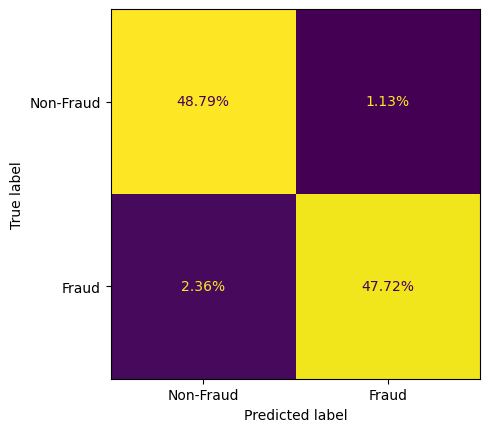

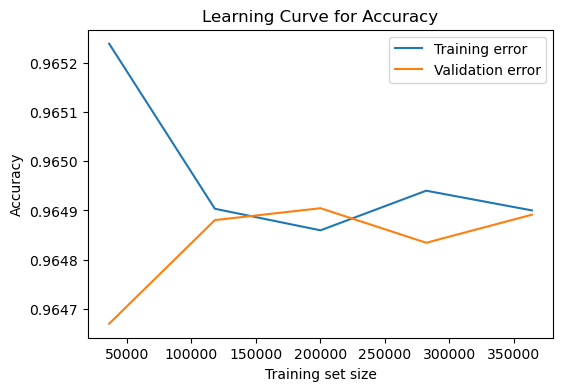

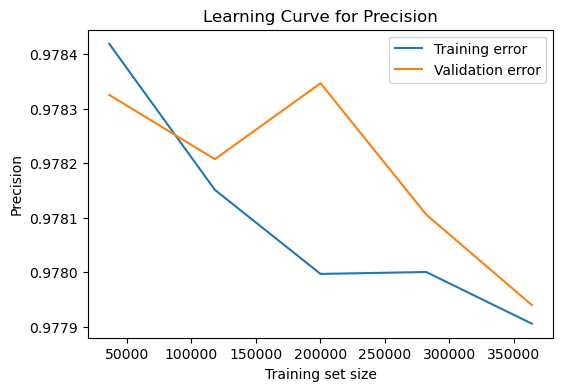

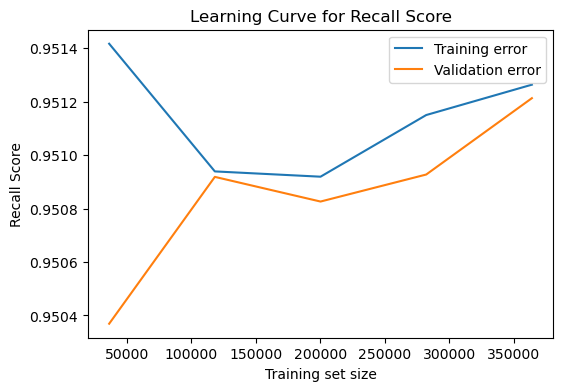

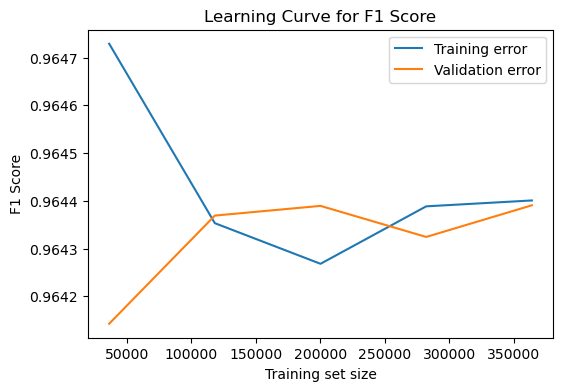

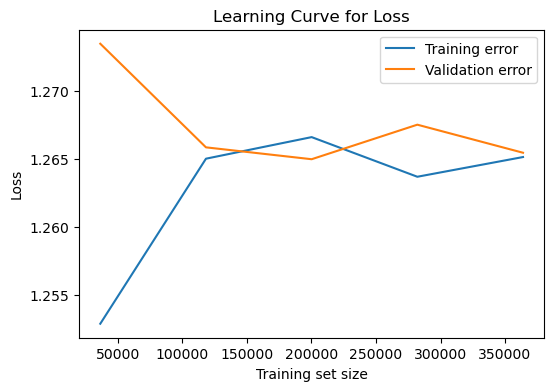

,Train,Validate
Metric,,
Accuracy,0.964808,0.965136
Precision,0.977869,0.976924
Recall,0.951112,0.952893
F1,0.964305,0.964759


In [12]:
y_pred = logistic.predict(X_test)
cm_log = cm(y_true=y_test,
            y_pred=y_pred,
            normalize='all')
metric_log = metrics(logistic,
                     X_train, 
                     y_train,
                     y_test,
                     y_pred)
for scoring in score:
    log_learning_curve = plot_learning_curve(logistic, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])
metric_log

# SGDClassifier


In [13]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(random_state=1)
SGD.fit(X_train, y_train)

SGDClassifier(random_state=1)

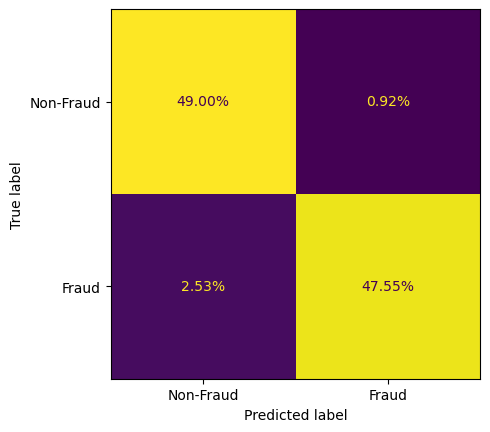

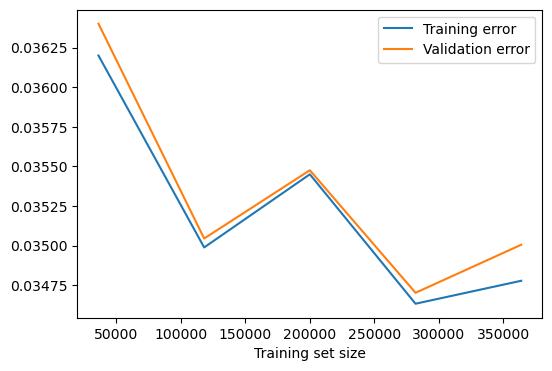

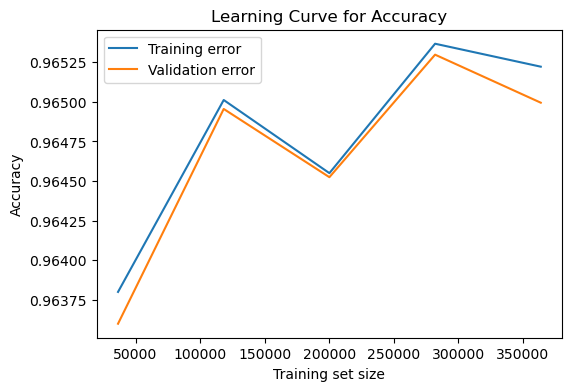

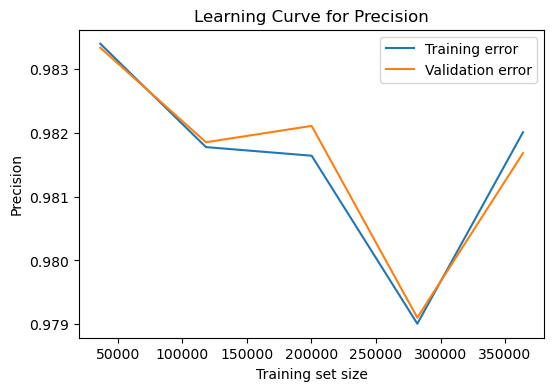

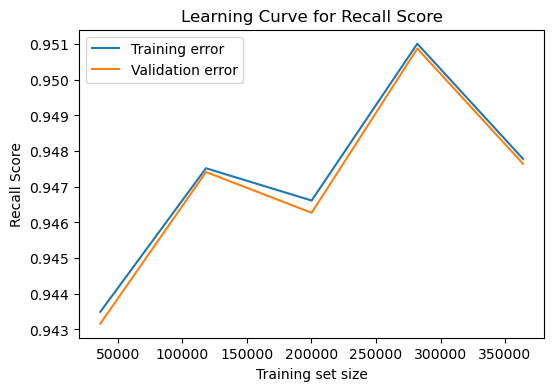

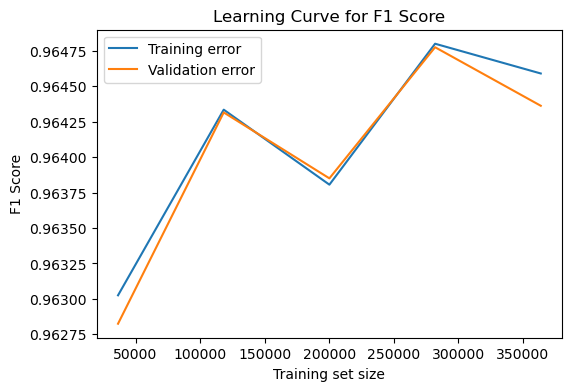

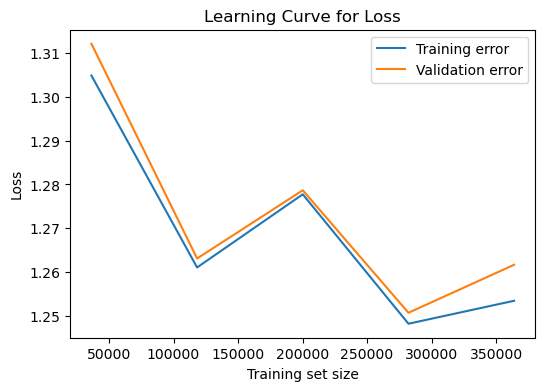

,Train,Validate
Metric,,
Accuracy,0.965351,0.965478
Precision,0.982083,0.981041
Recall,0.947968,0.949417
F1,0.964724,0.964970


In [14]:
SGD_pred = SGD.predict(X_test)
cm_SGD = cm(y_true=y_test,
            y_pred=SGD_pred,
            normalize='all')
metric_SGD = metrics(SGD,
                     X_train,
                     y_train,
                     y_test, 
                     SGD_pred)
SGD_learning = plot_learning_curve(SGD,
                                   X_train,
                                   y_train)
for scoring in score:
    SGD_learning_curve = plot_learning_curve(SGD, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

metric_SGD

# GaussianNB

In [15]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

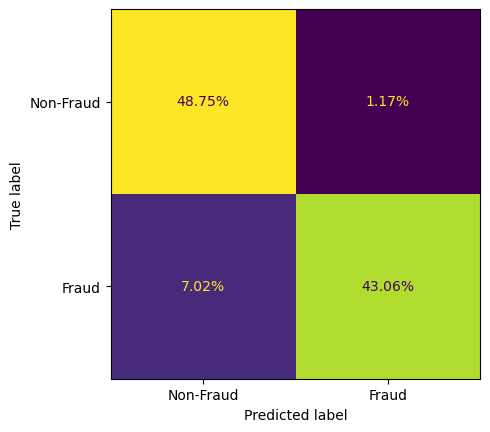

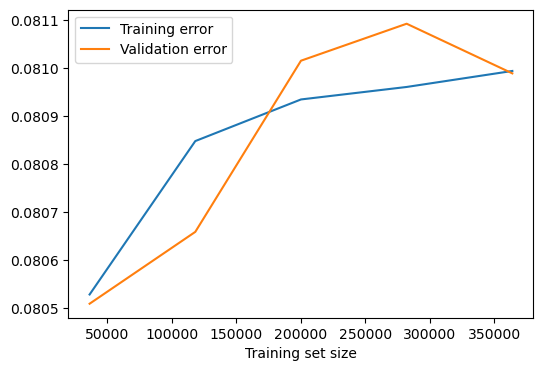

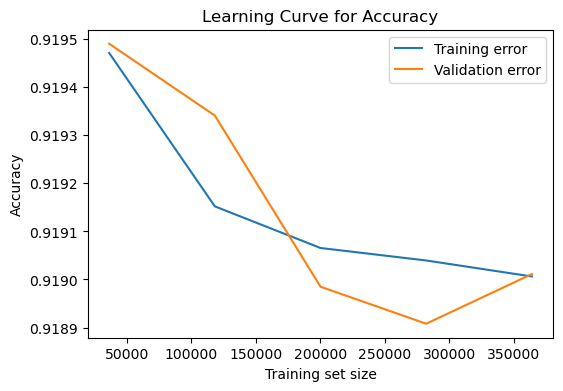

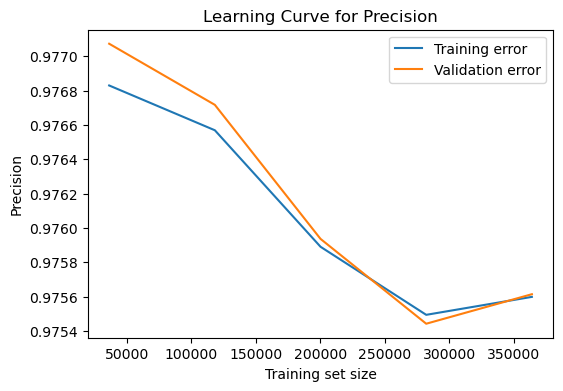

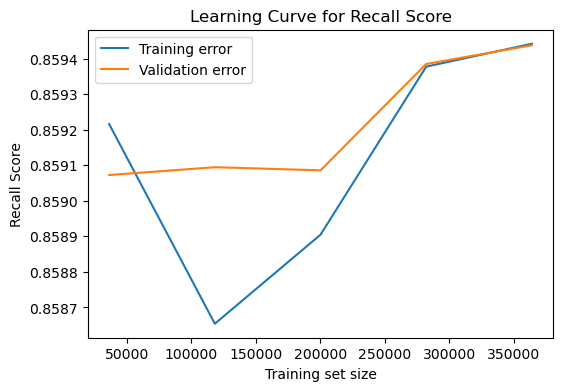

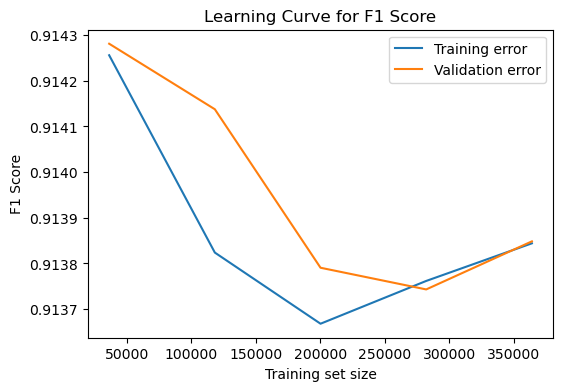

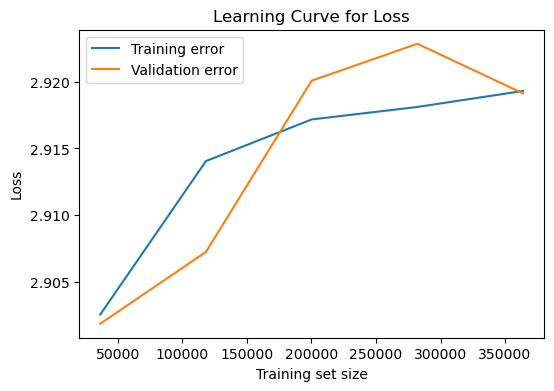

,Train,Validate
Metric,,
Accuracy,0.918886,0.918145
Precision,0.975589,0.973619
Recall,0.859204,0.859857
F1,0.913705,0.913208


In [16]:
GNB_pred = GNB.predict(X_test)
cm_GNB = cm(y_test,
            GNB_pred,
            normalize='all')
GNB_metrics = metrics(GNB,
                      X_train,
                      y_train,
                      y_test,
                      GNB_pred)
GNB_learning = plot_learning_curve(GNB,
                                   X_train,
                                   y_train)
for scoring in score:
    GNB_learning_curve = plot_learning_curve(GNB, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])
GNB_metrics

# CatBoost

In [17]:
from catboost import CatBoostClassifier
cgb = CatBoostClassifier(iterations=2,
                         depth=2,
                         learning_rate=0.01,
                         loss_function='Logloss',
                         verbose=False)
cgb.fit(X_train, y_train)

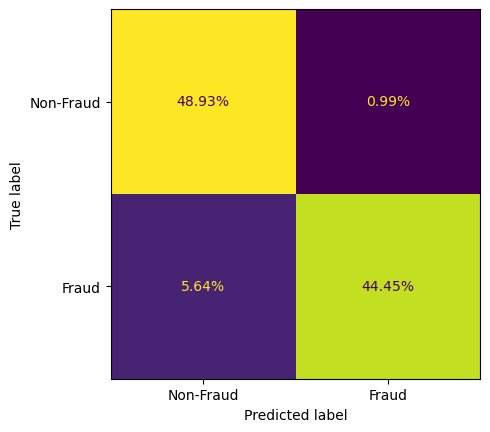

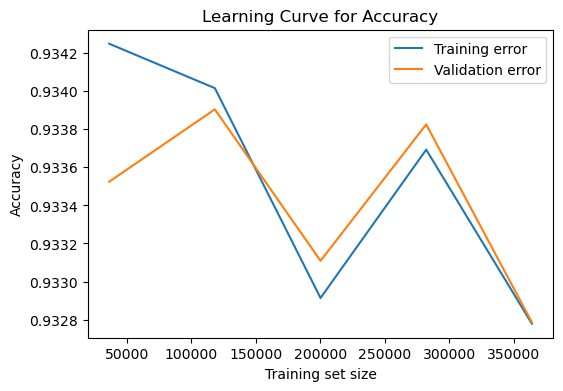

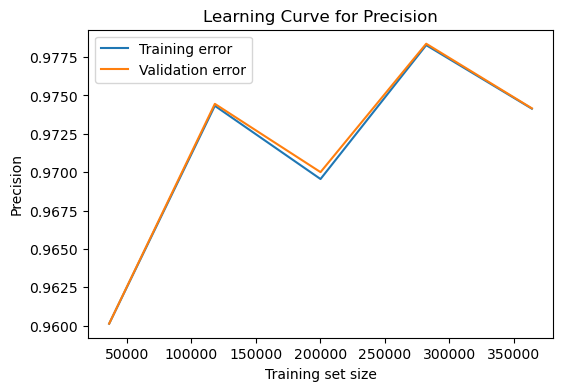

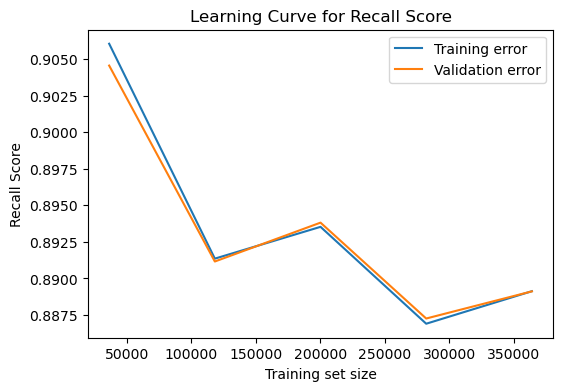

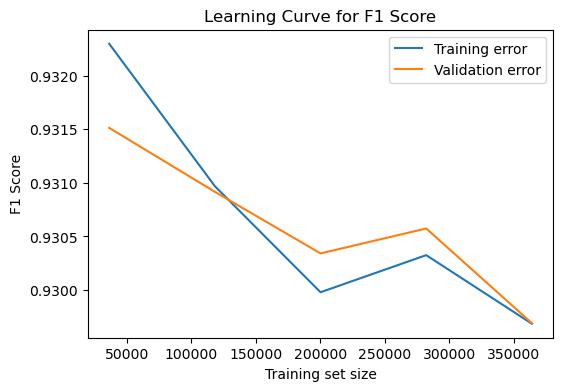

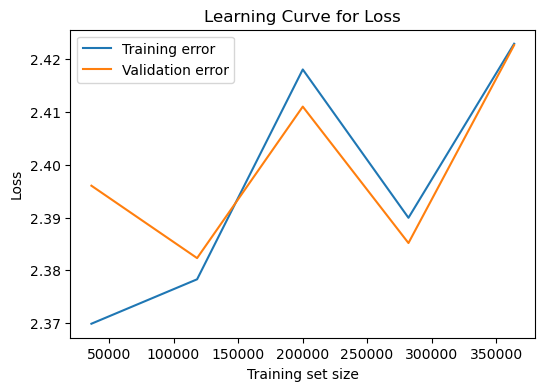

,Train,Validate
Metric,,
Accuracy,0.933698,0.933771
Precision,0.980900,0.978284
Recall,0.884565,0.887457
F1,0.930245,0.930660


In [18]:
cgb_pred = cgb.predict(X_test)
cm_cgb = cm(y_test,
            cgb_pred,
            normalize='all')
cgb_metrics = metrics(cgb,
                      X_train,
                      y_train,
                      y_test,
                      cgb_pred)
for scoring in score:
    cgb_learning_curve = plot_learning_curve(cgb, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])
cgb_metrics

# Neural Network

In [23]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def nn_model(hidden_layers, output_layers):
    # Declare the model
    model = Sequential()

    # Add layer
    model.add(Dense(hidden_layers, activation="relu"))
    model.add(Dense(hidden_layers, activation="relu"))
    model.add(Dense(output_layers, activation="sigmoid"))
    
    # Compile
    model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")
    return model

ANN = KerasClassifier(build_fn=nn_model, 
                      hidden_layers=100, 
                      output_layers=1)

/var/folders/5l/gpxf0q0109zg94jq7ssf5dj40000gn/T/ipykernel_41109/1633819957.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ANN = KerasClassifier(build_fn=nn_model,


In [24]:
ANN.fit(X_train, 
        y_train, 
        epochs=10, 
        batch_size=32)

Epoch 1/10
14216/14216 [==============================] - 14s 947us/step - loss: 0.0184 - accuracy: 0.9939
Epoch 2/10
14216/14216 [==============================] - 14s 976us/step - loss: 0.0052 - accuracy: 0.9986
Epoch 3/10
14216/14216 [==============================] - 14s 955us/step - loss: 0.0040 - accuracy: 0.9990
Epoch 4/10
14216/14216 [==============================] - 14s 978us/step - loss: 0.0030 - accuracy: 0.9992
Epoch 5/10
14216/14216 [==============================] - 14s 998us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 6/10
14216/14216 [==============================] - 15s 1ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 7/10
14216/14216 [==============================] - 18s 1ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 8/10
14216/14216 [==============================] - 20s 1ms/step - loss: 0.0021 - accuracy: 0.9995
Epoch 9/10
14216/14216 [==============================] - 18s 1ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 10/10
14216/14216 [====================

11373/11373 [==============================] - 10s 873us/step


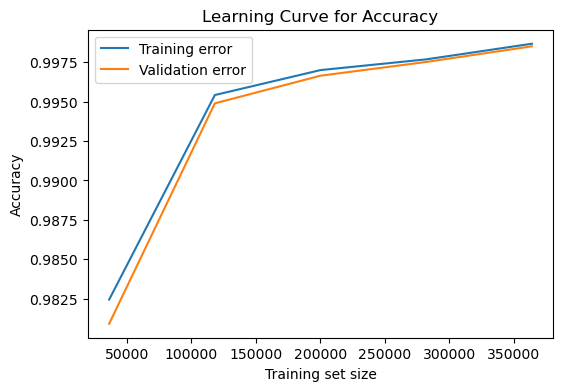

11373/11373 [==============================] - 13s 1ms/step


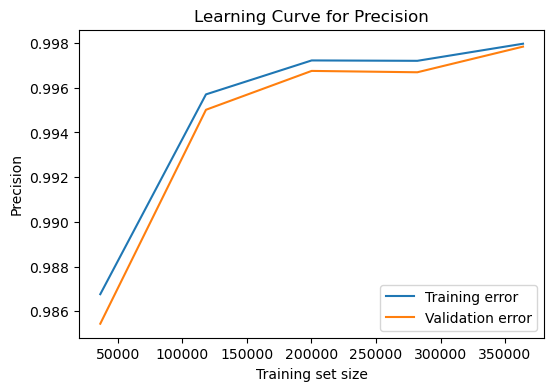

11373/11373 [==============================] - 10s 867us/step


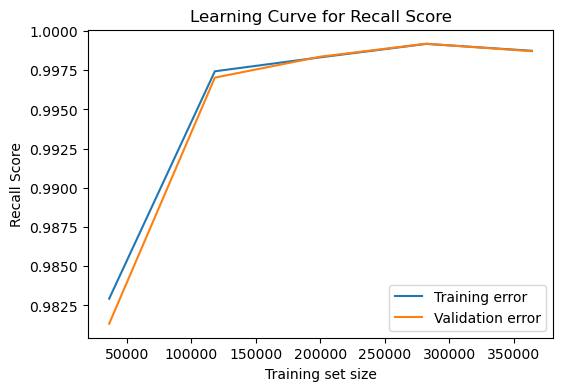

11373/11373 [==============================] - 10s 856us/step


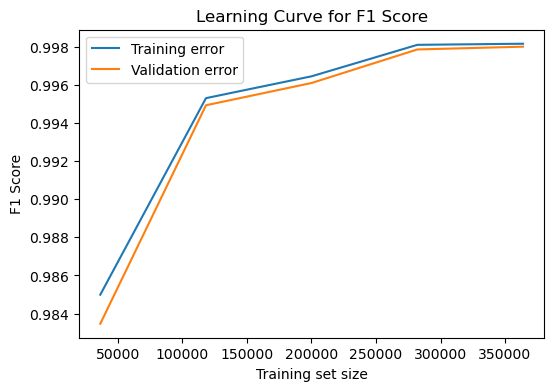

11373/11373 [==============================] - 12s 1ms/step


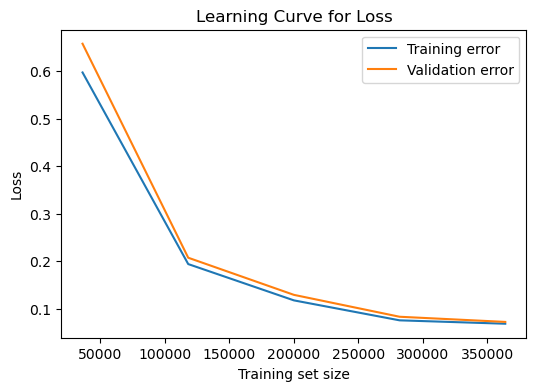

In [25]:
for scoring in score:
    ann_learning_curve = plot_learning_curve(ANN, 
                                             X_train, 
                                             y_train,
                                             scoring=score[scoring])

In [ ]:
plot_learning_curve(ANN,
                    X_train, 
                    y_train)

3554/3554 [==============================] - 3s 863us/step


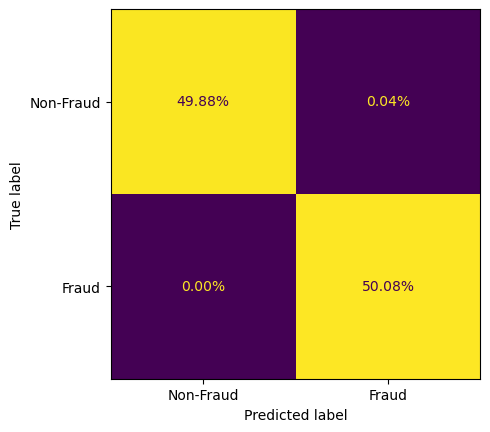

4739/4739 [==============================] - 4s 891us/step


,Train,Validate
Metric,,
Accuracy,0.997940,0.999569
Precision,0.998038,0.999140
Recall,0.997840,1.000000
F1,0.997939,0.999570


In [26]:
nn_pred = model_nn.predict(X_test)
nn_pred_binary = (nn_pred > 0.5).astype(int)

cm_nn = cm(y_true=y_test,
           y_pred=nn_pred_binary,
           normalize='all')
nn_metrics = metrics(ANN,
                     X_train,
                     y_train,
                     y_test, 
                     nn_pred_binary)
nn_metrics